# Import dependencies

In [1]:
try:
    import cleverhans
except ImportError:
    !pip install cleverhans

  Using cached https://files.pythonhosted.org/packages/ac/a0/f0b4386b719f343c4ed3e13cd7792a7a7a4674566ca9b2b34a09b7424220/cleverhans-3.0.1-py3-none-any.whl
     |████████████████████████████████| 51kB 2.0MB/s eta 0:00:011
  Using cached https://files.pythonhosted.org/packages/f8/72/29ef1e5f386b65544d4e7002dfeca1e55b099ed182cd6d405c21a19ae259/tensorflow_probability-0.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c6/c4/5db3bfe009f8d71f1d532bbadbd0ec203764bba3a469e4703a889db8e5e0/mnist-0.2.2-py2.py3-none-any.whl
     |████████████████████████████████| 163kB 6.1MB/s eta 0:00:01
     |████████████████████████████████| 14.4MB 23.2MB/s eta 0:00:01    |█████████████████▊              | 8.0MB 23.2MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/24/fb/4f92f8c0f40a0d728b4f3d5ec5ff84353e705d8ff5e3e447620ea98b06bd/cloudpickle-1.1.1-py2.py3-none-any.whl
     |████████████████████████████████| 122kB 4.3MB/s eta 0:00:01
     |███████████████████

In [11]:
from cleverhans.attacks import ProjectedGradientDescent
from cleverhans.model import Model as CleverhansModel
from io import BytesIO
import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import requests
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [13]:
tf.logging.set_verbosity(tf.logging.ERROR)

# Define model wrapper for cleverhans

In [14]:
class InceptionV1Model(CleverhansModel):
    SCOPE = 'inceptionv1'
    SOFTMAX_OP = 'softmax2'
  
    def __init__(self):
        super(InceptionV1Model, self).__init__()
        self._model = models.InceptionV1()
        self._model.load_graphdef()
        self._fprop_cache = dict()

    def fprop(self, x):
        if x not in self._fprop_cache:
            # https://github.com/tensorflow/lucid/blob/67e19f38c315e548034c3e4315dfee6f718df916/lucid/modelzoo/vision_base.py#L189
            graph = x.graph
            scope = graph.unique_name(
              '%sfprop%d' % (self.SCOPE, len(self._fprop_cache)), False)
            _, x_prep = self._model.create_input(x, forget_xy_shape=True)
            final_input_map = {self._model.input_name: x_prep}
            ops = tf.import_graph_def(self._model.graph_def, final_input_map,
                                    return_elements=[self.SOFTMAX_OP], name=scope)
            self._model.post_import(scope)

            softmax2_op = ops[0]
            logits = softmax2_op.inputs[0]
            logits = logits[:, :1000]

            self._fprop_cache[x] = {'logits' : logits}

        return self._fprop_cache[x]

# Define utility functions

In [15]:
def load_image_from_url(img_url, resize_to=(224, 224)):
    img_response = requests.get(img_url)
    img = Image.open(BytesIO(img_response.content))
    if resize_to is not None:
        img = img.resize(resize_to)
    img = np.array(img)
    return img

In [16]:
def load_image_from_file(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    return img

In [17]:
def get_predictions(model, imgs):
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:  
        x = tf.placeholder(tf.float32, (None, 224, 224, 3))
        y = model.get_probs(x)
        y = tf.arg_max(y, 1)
        y_eval = sess.run(y, feed_dict={x: imgs})

    return y_eval

In [18]:
def attack_images(model, imgs):
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:
        x = tf.placeholder(tf.float32, (None, 224, 224, 3))

        attack = ProjectedGradientDescent(model, sess=sess)
        attack_kwargs = {'eps': 16, 'eps_iter': 1.0, 'nb_iter': 20}

        adv_imgs = attack.generate(x, **attack_kwargs)
        adv_imgs_eval = sess.run(adv_imgs, feed_dict={x: imgs})

    return adv_imgs_eval

# Initialize model and load image

In [19]:
model = InceptionV1Model()

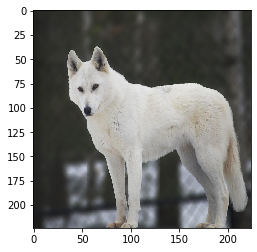

In [20]:
# Get an input image from url
img_url = ('https://images.fineartamerica.com/images/artworkimages'
           '/mediumlarge/1/white-wolf-elaine-mikkelstrup.jpg')

img = load_image_from_url(img_url)
plt.imshow(img)

# Experiments

## Get prediction on benign image

In [21]:
get_predictions(model, [img]) # 102 -> white_wolf

array([102])

## Generate attacked image

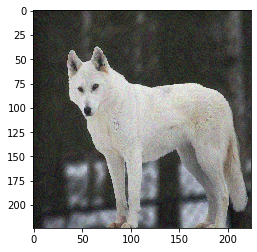

In [22]:
adv_imgs = attack_images(model, [img])

adv_img = adv_imgs[0]
plt.imshow(np.array(adv_img, dtype=np.uint8))

## Get prediction on adversarial image

In [23]:
get_predictions(model, [adv_img])

array([189])